In [ ]:
!pip install --upgrade xgboost scikit-learn
!pip install optuna

In [145]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import  confusion_matrix, roc_auc_score, precision_recall_curve, precision_score, recall_score , make_scorer , f1_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [93]:
X = pd.read_csv('/content/drive/MyDrive/task_artsai/interview.X.csv')

In [94]:
y = pd.read_csv('/content/drive/MyDrive/task_artsai/interview.y.csv')

***Анализ пропущенных значений***

In [5]:
X.isnull().sum()

,0
reg_time,0
uid,0
fc_imp_chk,0
fc_time_chk,0
utmtr,0
mm_dma,0
osName,7892
model,8395
hardware,8185
site_id,0


***Статистическое описание цифровых данных***

In [6]:
X.describe()

,fc_imp_chk,fc_time_chk,utmtr,mm_dma
count,955239.000000,955239.000000,955239.000000,955239.000000
mean,0.185832,6.914158,3.258058,523.416025
std,0.715118,0.280967,2.372753,130.622881
min,-1.000000,-1.000000,0.000000,0.000000
25%,0.000000,7.000000,1.000000,505.000000
50%,0.000000,7.000000,3.000000,524.000000
75%,0.000000,7.000000,5.000000,567.000000
max,4.000000,7.000000,7.000000,881.000000


***Распределение цифривых переменных***

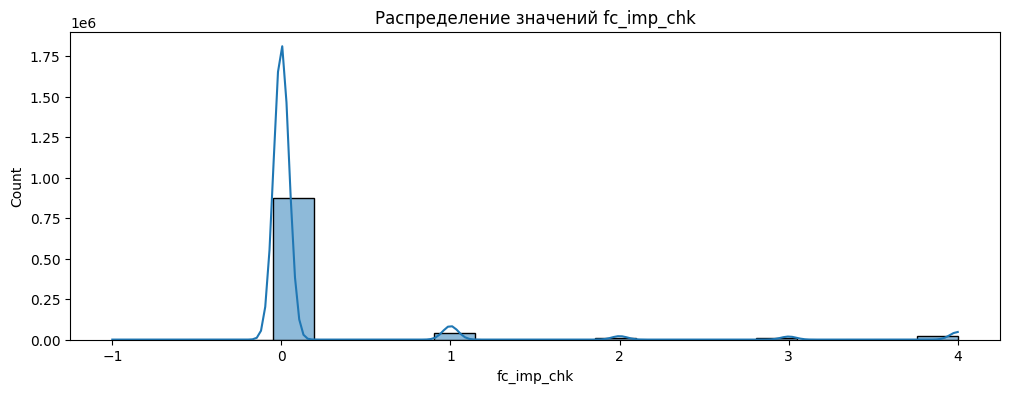

In [7]:
plt.figure(figsize=(12, 4))
sns.histplot(X['fc_imp_chk'], kde=True, label='fc_imp_chk')
plt.title('Распределение значений fc_imp_chk')
plt.show()

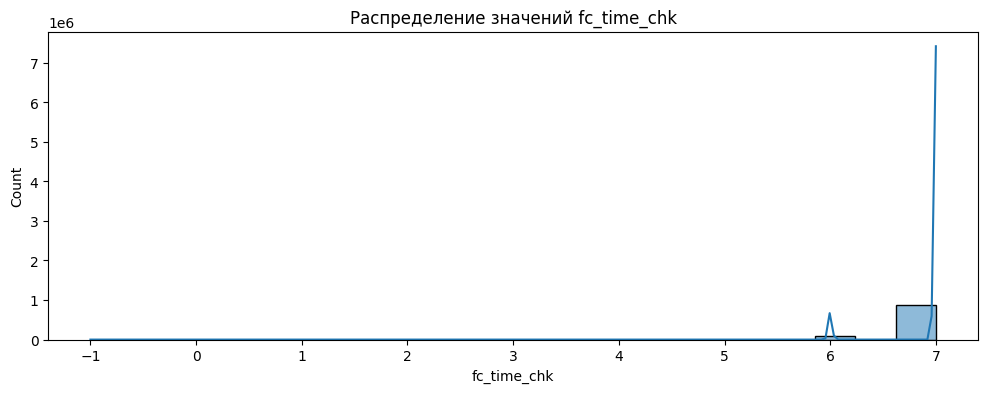

In [8]:
plt.figure(figsize=(12, 4))
sns.histplot(X['fc_time_chk'], kde=True, label='fc_time_chk')
plt.title('Распределение значений fc_time_chk')
plt.show()

указывает на случаи, когда не было предыдущего показа. ^

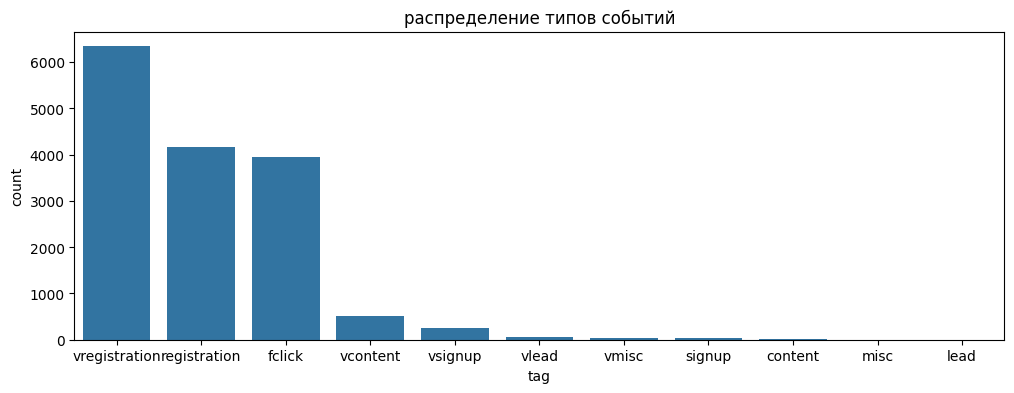

In [9]:
plt.figure(figsize=(12, 4))
sns.countplot(data=y, x='tag', order=y['tag'].value_counts().index)
plt.title('распределение типов событий')
plt.show()

***Обядинение датасетов***

In [10]:
np.unique(y['tag'])

array(['content', 'fclick', 'lead', 'misc', 'registration', 'signup',
       'vcontent', 'vlead', 'vmisc', 'vregistration', 'vsignup'],
      dtype=object)

In [95]:
data = pd.merge(X, y, how='left', on='uid')

In [96]:
data.isna().sum()

,0
reg_time,0
uid,0
fc_imp_chk,0
fc_time_chk,0
utmtr,0
mm_dma,0
osName,7936
model,8441
hardware,8231
site_id,0


In [97]:
data['osName'] = data['osName'].fillna(data['osName'].mode()[0])
data['model'] = data['model'].fillna(data['model'].mode()[0])
data['hardware'] = data['hardware'].fillna(data['hardware'].mode()[0])

In [98]:
data['tag'] = data['tag'].fillna('no_event')

In [99]:
data['is_fclick'] = (data['tag']=="fclick").astype(int)
data['is_content'] = (data['tag']=="content").astype(int)
data['is_lead'] = (data['tag']=="lead").astype(int)
data['is_misc'] = (data['tag']=="misc").astype(int)
data['is_registration'] = (data['tag']=="registration").astype(int)
data['is_signup'] = (data['tag']=="signup").astype(int)
data['is_vcontent'] = (data['tag']=="vcontent").astype(int)
data['is_vlead'] = (data['tag']=="vlead").astype(int)
data['is_vmisc'] = (data['tag']=="vmisc").astype(int)
data['is_vregistration'] = (data['tag']=="vregistration").astype(int)
data['is_vsignup'] = (data['tag']=="vsignup").astype(int)

***Корреляционный анализ для ранговых переменных***

In [100]:
from scipy.stats import spearmanr

In [101]:
binary_vars = ['is_fclick', 'is_content', 'is_lead', 'is_misc', 'is_registration', 'is_signup',
               'is_vcontent', 'is_vlead', 'is_vmisc', 'is_vregistration', 'is_vsignup']

In [102]:
ranked_vars  = ['fc_imp_chk', 'fc_time_chk', 'utmtr']

In [103]:
def correl(data, X , y):
  correlations = {}
  for feature in X:
      spearman_coef, _ = spearmanr(data[feature], data[y])
      correlations[feature] = spearman_coef
  return correlations

In [104]:
for target in binary_vars:
  correlations = correl(data ,ranked_vars, target)
  for feature, corr in correlations.items():
      print(f" Корреляция {feature} с {target} = {corr}")

 Корреляция fc_imp_chk с is_fclick = 0.021638863837608206
 Корреляция fc_time_chk с is_fclick = -0.02149268967147765
 Корреляция utmtr с is_fclick = 0.008074984238438778
 Корреляция fc_imp_chk с is_content = 0.0007880919042188631
 Корреляция fc_time_chk с is_content = -0.0006717093418465588
 Корреляция utmtr с is_content = 0.0003120744560600478
 Корреляция fc_imp_chk с is_lead = -0.0007641400932537941
 Корреляция fc_time_chk с is_lead = 0.0007651659387292092
 Корреляция utmtr с is_lead = -8.00301346406617e-06
 Корреляция fc_imp_chk с is_misc = -0.0006975609140059182
 Корреляция fc_time_chk с is_misc = 0.000698497378031006
 Корреляция utmtr с is_misc = -0.00026484495319012544
 Корреляция fc_imp_chk с is_registration = 0.003003529344098006
 Корреляция fc_time_chk с is_registration = -0.0029144247809790346
 Корреляция utmtr с is_registration = 0.008220237525388063
 Корреляция fc_imp_chk с is_signup = -0.0001330333697640348
 Корреляция fc_time_chk с is_signup = 0.00022074753863116873
 Корр

***Корреляционный анализ для непрерывной переменной***

In [105]:
for target in binary_vars:
  correlation = data['mm_dma'].corr(data[target])
  print(f"Kорреляция mm_dma с {target} = {correlation}")

Kорреляция mm_dma с is_fclick = -0.00684563568787637
Kорреляция mm_dma с is_content = 0.0001417372118216445
Kорреляция mm_dma с is_lead = -0.006793366266662664
Kорреляция mm_dma с is_misc = -0.003056907484655515
Kорреляция mm_dma с is_registration = -0.002370475335924214
Kорреляция mm_dma с is_signup = 0.0007116232100361786
Kорреляция mm_dma с is_vcontent = -0.00018814999982515664
Kорреляция mm_dma с is_vlead = -0.002128685659184843
Kорреляция mm_dma с is_vmisc = -0.001544603989450679
Kорреляция mm_dma с is_vregistration = -0.01006532264028723
Kорреляция mm_dma с is_vsignup = -0.001242554916991584


***Берем нам нужны
е фичи для строения модели***

In [106]:
data = data.loc[:,['fc_imp_chk', 'fc_time_chk', 'utmtr' ,'mm_dma', 'osName',	'model',	'hardware',	'site_id' , 'is_fclick']]

In [107]:
data = data.rename(columns={'is_fclick':'fclick'})

***Делим дату на 2 части (train , test) для создании модели , корреляционный анализ показал что нет связи между X и y***

In [108]:
X = data.drop('fclick', axis=1)

In [109]:
y = data['fclick']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

***Преобразование категориальных переменных в числовые***

In [111]:
!pip install category_encoders

In [112]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

In [113]:
features_to_encode = ['osName', 'model', 'hardware', 'site_id']

In [114]:
encoder = ce.OrdinalEncoder(cols=features_to_encode, handle_unknown='impute')

In [115]:
X_train_encoded = encoder.fit_transform(X_train)

In [116]:
X_test_encoded = encoder.transform(X_test)

***Так как корреляции нету можно выбрать нелинейные модели.***

In [120]:
!pip install lightgbm


In [121]:
import lightgbm as lgb

In [123]:
train_data = lgb.Dataset(X_train_encoded, label=y_train)
test_data = lgb.Dataset(X_test_encoded, label=y_test, reference=train_data)

In [122]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'scale_pos_weight': 121  # Это предполагаемое значение для дисбаланса классов
}

In [124]:
gbm = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


In [125]:
y_pred = gbm.predict(X_test_encoded)
y_pred_binary = (y_pred >= 0.5).astype(int)

In [127]:
f1 = f1_score(y_test, y_pred_binary)
print(f"F1-Score: {f1:.4f}")


F1-Score: 0.0212


In [129]:
#xgb_class = XGBClassifier(scale_pos_weight=121, random_state=42)

In [128]:
#XGBClassifier()

In [130]:
#xgb_class.fit(X_train_encoded, y_train)

In [131]:
#y_pred = xgb_class.predict(X_test_encoded)

In [132]:
model = RandomForestClassifier(class_weight={0: 1, 1: 121}, random_state=42)

In [133]:
cv = StratifiedKFold(n_splits=5)

In [134]:
scores = cross_val_score(model, X_train_encoded, y_train, cv=cv, scoring=make_scorer(f1_score))

In [135]:
print(scores)

[0.03900536 0.03711391 0.03307795 0.0394862  0.0340644 ]


In [136]:
print('Mean ROC AUC: %.5f' % scores.mean())

Mean ROC AUC: 0.03655


In [138]:
model.fit(X_train_encoded, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 121}, random_state=42)

In [141]:
y_pred_forest = model.predict(X_test_encoded)

In [142]:
print(classification_report(y_test,y_pred_forest))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    191403
           1       0.02      0.29      0.04       794

    accuracy                           0.94    192197
   macro avg       0.51      0.62      0.50    192197
weighted avg       0.99      0.94      0.97    192197



***Сделаем тюнинг гиперпараметров , так как у нас есть недообучение***

In [148]:
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_samples_split": trial.suggest_int("min_samples_split", 2 ,5),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 150)
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_encoded, y_train)

    # Get the predicted probabilities
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    # Return the ROC-AUC score (as the objective to maximize)
    return roc_auc_score(y_test, y_pred_proba)
    #score = cross_val_score(model, X_train, y_train, n_jobs=-1,scoring='roc_auc', cv=5).mean()
    #return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best value:", study.best_value)

[I 2024-12-25 12:30:42,761] A new study created in memory with name: no-name-d1849631-40d8-47de-8ea2-dc923169f3ba


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:30:48,683] Trial 0 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 467, 'min_samples_split': 3, 'scale_pos_weight': 10}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:30:56,178] Trial 1 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 856, 'min_samples_split': 4, 'scale_pos_weight': 87}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:31:02,194] Trial 2 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 973, 'min_samples_split': 4, 'scale_pos_weight': 57}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:31:10,297] Trial 3 finished with value: 0.6135727199672902 and parameters: {'max_depth': 9, 'n_estimators': 378, 'min_samples_split': 3, 'scale_pos_weight': 89}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:31:16,796] Trial 4 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 794, 'min_samples_split': 4, 'scale_pos_weight': 47}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:31:22,631] Trial 5 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 416, 'min_samples_split': 5, 'scale_pos_weight': 29}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:31:30,143] Trial 6 finished with value: 0.6135727199672902 and parameters: {'max_depth': 10, 'n_estimators': 962, 'min_samples_split': 2, 'scale_pos_weight': 34}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:31:35,948] Trial 7 finished with value: 0.6135727199672902 and parameters: {'max_depth': 3, 'n_estimators': 147, 'min_samples_split': 3, 'scale_pos_weight': 76}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:31:43,890] Trial 8 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 725, 'min_samples_split': 2, 'scale_pos_weight': 72}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:31:49,707] Trial 9 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 540, 'min_samples_split': 3, 'scale_pos_weight': 116}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:31:56,116] Trial 10 finished with value: 0.6135727199672902 and parameters: {'max_depth': 8, 'n_estimators': 68, 'min_samples_split': 5, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:32:03,028] Trial 11 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 633, 'min_samples_split': 4, 'scale_pos_weight': 120}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:32:08,812] Trial 12 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 285, 'min_samples_split': 4, 'scale_pos_weight': 99}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:32:16,783] Trial 13 finished with value: 0.6135727199672902 and parameters: {'max_depth': 4, 'n_estimators': 823, 'min_samples_split': 3, 'scale_pos_weight': 139}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:32:22,578] Trial 14 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 582, 'min_samples_split': 2, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:32:29,581] Trial 15 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 429, 'min_samples_split': 5, 'scale_pos_weight': 23}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:32:35,948] Trial 16 finished with value: 0.6135727199672902 and parameters: {'max_depth': 4, 'n_estimators': 678, 'min_samples_split': 3, 'scale_pos_weight': 149}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:32:41,889] Trial 17 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 268, 'min_samples_split': 4, 'scale_pos_weight': 59}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:32:49,075] Trial 18 finished with value: 0.6135727199672902 and parameters: {'max_depth': 4, 'n_estimators': 841, 'min_samples_split': 3, 'scale_pos_weight': 100}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:32:54,866] Trial 19 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 472, 'min_samples_split': 4, 'scale_pos_weight': 16}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:33:02,357] Trial 20 finished with value: 0.6135727199672902 and parameters: {'max_depth': 8, 'n_estimators': 326, 'min_samples_split': 2, 'scale_pos_weight': 78}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:33:08,182] Trial 21 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 989, 'min_samples_split': 4, 'scale_pos_weight': 57}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:33:14,763] Trial 22 finished with value: 0.6135727199672902 and parameters: {'max_depth': 3, 'n_estimators': 919, 'min_samples_split': 4, 'scale_pos_weight': 50}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:33:21,466] Trial 23 finished with value: 0.6135727199672902 and parameters: {'max_depth': 3, 'n_estimators': 894, 'min_samples_split': 5, 'scale_pos_weight': 40}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:33:27,303] Trial 24 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 745, 'min_samples_split': 4, 'scale_pos_weight': 65}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:33:34,692] Trial 25 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 891, 'min_samples_split': 3, 'scale_pos_weight': 14}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:33:40,612] Trial 26 finished with value: 0.6135727199672902 and parameters: {'max_depth': 8, 'n_estimators': 594, 'min_samples_split': 4, 'scale_pos_weight': 89}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:33:47,622] Trial 27 finished with value: 0.6135727199672902 and parameters: {'max_depth': 4, 'n_estimators': 1000, 'min_samples_split': 5, 'scale_pos_weight': 116}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:33:53,769] Trial 28 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 504, 'min_samples_split': 3, 'scale_pos_weight': 85}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:34:00,130] Trial 29 finished with value: 0.6135727199672902 and parameters: {'max_depth': 9, 'n_estimators': 723, 'min_samples_split': 3, 'scale_pos_weight': 100}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:34:07,133] Trial 30 finished with value: 0.6135727199672902 and parameters: {'max_depth': 3, 'n_estimators': 204, 'min_samples_split': 4, 'scale_pos_weight': 45}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:34:13,224] Trial 31 finished with value: 0.6135727199672902 and parameters: {'max_depth': 10, 'n_estimators': 350, 'min_samples_split': 3, 'scale_pos_weight': 95}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:34:20,302] Trial 32 finished with value: 0.6135727199672902 and parameters: {'max_depth': 9, 'n_estimators': 429, 'min_samples_split': 3, 'scale_pos_weight': 86}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:34:26,158] Trial 33 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 338, 'min_samples_split': 4, 'scale_pos_weight': 109}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:34:33,266] Trial 34 finished with value: 0.6135727199672902 and parameters: {'max_depth': 9, 'n_estimators': 375, 'min_samples_split': 2, 'scale_pos_weight': 67}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:34:39,105] Trial 35 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 937, 'min_samples_split': 3, 'scale_pos_weight': 34}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:34:45,916] Trial 36 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 480, 'min_samples_split': 4, 'scale_pos_weight': 128}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:34:52,120] Trial 37 finished with value: 0.6135727199672902 and parameters: {'max_depth': 10, 'n_estimators': 796, 'min_samples_split': 2, 'scale_pos_weight': 82}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:34:58,425] Trial 38 finished with value: 0.6135727199672902 and parameters: {'max_depth': 8, 'n_estimators': 553, 'min_samples_split': 3, 'scale_pos_weight': 72}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:35:05,139] Trial 39 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 631, 'min_samples_split': 4, 'scale_pos_weight': 110}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:35:10,958] Trial 40 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 222, 'min_samples_split': 5, 'scale_pos_weight': 53}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:35:18,027] Trial 41 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 855, 'min_samples_split': 4, 'scale_pos_weight': 26}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:35:23,879] Trial 42 finished with value: 0.6135727199672902 and parameters: {'max_depth': 4, 'n_estimators': 767, 'min_samples_split': 4, 'scale_pos_weight': 64}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:35:30,954] Trial 43 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 680, 'min_samples_split': 4, 'scale_pos_weight': 41}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:35:36,782] Trial 44 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 946, 'min_samples_split': 3, 'scale_pos_weight': 75}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:35:43,746] Trial 45 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 865, 'min_samples_split': 5, 'scale_pos_weight': 94}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:35:49,774] Trial 46 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 403, 'min_samples_split': 4, 'scale_pos_weight': 15}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:35:56,155] Trial 47 finished with value: 0.6135727199672902 and parameters: {'max_depth': 4, 'n_estimators': 76, 'min_samples_split': 3, 'scale_pos_weight': 4}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:36:02,767] Trial 48 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 795, 'min_samples_split': 4, 'scale_pos_weight': 31}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:36:08,589] Trial 49 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 969, 'min_samples_split': 2, 'scale_pos_weight': 48}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:36:15,684] Trial 50 finished with value: 0.6135727199672902 and parameters: {'max_depth': 3, 'n_estimators': 465, 'min_samples_split': 3, 'scale_pos_weight': 59}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:36:21,538] Trial 51 finished with value: 0.6135727199672902 and parameters: {'max_depth': 9, 'n_estimators': 281, 'min_samples_split': 5, 'scale_pos_weight': 9}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:36:28,619] Trial 52 finished with value: 0.6135727199672902 and parameters: {'max_depth': 8, 'n_estimators': 423, 'min_samples_split': 5, 'scale_pos_weight': 23}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:36:34,433] Trial 53 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 527, 'min_samples_split': 5, 'scale_pos_weight': 32}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:36:41,493] Trial 54 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 904, 'min_samples_split': 4, 'scale_pos_weight': 38}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:36:47,316] Trial 55 finished with value: 0.6135727199672902 and parameters: {'max_depth': 4, 'n_estimators': 309, 'min_samples_split': 3, 'scale_pos_weight': 20}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:36:53,744] Trial 56 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 391, 'min_samples_split': 4, 'scale_pos_weight': 53}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:37:00,136] Trial 57 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 614, 'min_samples_split': 3, 'scale_pos_weight': 71}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:37:06,268] Trial 58 finished with value: 0.6135727199672902 and parameters: {'max_depth': 3, 'n_estimators': 676, 'min_samples_split': 5, 'scale_pos_weight': 9}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:37:13,169] Trial 59 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 445, 'min_samples_split': 4, 'scale_pos_weight': 79}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:37:19,022] Trial 60 finished with value: 0.6135727199672902 and parameters: {'max_depth': 8, 'n_estimators': 573, 'min_samples_split': 4, 'scale_pos_weight': 42}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:37:26,082] Trial 61 finished with value: 0.6135727199672902 and parameters: {'max_depth': 10, 'n_estimators': 969, 'min_samples_split': 2, 'scale_pos_weight': 27}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:37:32,016] Trial 62 finished with value: 0.6135727199672902 and parameters: {'max_depth': 10, 'n_estimators': 831, 'min_samples_split': 2, 'scale_pos_weight': 36}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:37:39,045] Trial 63 finished with value: 0.6135727199672902 and parameters: {'max_depth': 9, 'n_estimators': 928, 'min_samples_split': 2, 'scale_pos_weight': 47}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:37:44,881] Trial 64 finished with value: 0.6135727199672902 and parameters: {'max_depth': 10, 'n_estimators': 884, 'min_samples_split': 2, 'scale_pos_weight': 92}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:37:51,801] Trial 65 finished with value: 0.6135727199672902 and parameters: {'max_depth': 9, 'n_estimators': 371, 'min_samples_split': 3, 'scale_pos_weight': 59}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:37:57,938] Trial 66 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 953, 'min_samples_split': 4, 'scale_pos_weight': 107}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:38:04,377] Trial 67 finished with value: 0.6135727199672902 and parameters: {'max_depth': 10, 'n_estimators': 1000, 'min_samples_split': 3, 'scale_pos_weight': 19}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:38:10,988] Trial 68 finished with value: 0.6135727199672902 and parameters: {'max_depth': 4, 'n_estimators': 798, 'min_samples_split': 4, 'scale_pos_weight': 29}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:38:16,819] Trial 69 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 502, 'min_samples_split': 5, 'scale_pos_weight': 11}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:38:23,914] Trial 70 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 867, 'min_samples_split': 3, 'scale_pos_weight': 43}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:38:29,708] Trial 71 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 119, 'min_samples_split': 3, 'scale_pos_weight': 83}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:38:36,802] Trial 72 finished with value: 0.6135727199672902 and parameters: {'max_depth': 3, 'n_estimators': 232, 'min_samples_split': 3, 'scale_pos_weight': 66}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:38:42,601] Trial 73 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 186, 'min_samples_split': 3, 'scale_pos_weight': 89}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:38:49,669] Trial 74 finished with value: 0.6135727199672902 and parameters: {'max_depth': 3, 'n_estimators': 159, 'min_samples_split': 2, 'scale_pos_weight': 103}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:38:55,488] Trial 75 finished with value: 0.6135727199672902 and parameters: {'max_depth': 8, 'n_estimators': 906, 'min_samples_split': 3, 'scale_pos_weight': 77}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:39:02,086] Trial 76 finished with value: 0.6135727199672902 and parameters: {'max_depth': 9, 'n_estimators': 709, 'min_samples_split': 4, 'scale_pos_weight': 55}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:39:08,534] Trial 77 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 315, 'min_samples_split': 4, 'scale_pos_weight': 50}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:39:14,503] Trial 78 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 359, 'min_samples_split': 3, 'scale_pos_weight': 62}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:39:21,316] Trial 79 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 57, 'min_samples_split': 3, 'scale_pos_weight': 71}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:39:27,132] Trial 80 finished with value: 0.6135727199672902 and parameters: {'max_depth': 4, 'n_estimators': 974, 'min_samples_split': 5, 'scale_pos_weight': 81}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:39:34,214] Trial 81 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 775, 'min_samples_split': 2, 'scale_pos_weight': 75}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:39:40,069] Trial 82 finished with value: 0.6135727199672902 and parameters: {'max_depth': 3, 'n_estimators': 843, 'min_samples_split': 2, 'scale_pos_weight': 97}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:39:47,119] Trial 83 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 817, 'min_samples_split': 2, 'scale_pos_weight': 70}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:39:52,928] Trial 84 finished with value: 0.6135727199672902 and parameters: {'max_depth': 3, 'n_estimators': 761, 'min_samples_split': 2, 'scale_pos_weight': 145}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:39:59,696] Trial 85 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 252, 'min_samples_split': 2, 'scale_pos_weight': 89}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:40:05,849] Trial 86 finished with value: 0.6135727199672902 and parameters: {'max_depth': 4, 'n_estimators': 731, 'min_samples_split': 4, 'scale_pos_weight': 5}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:40:12,066] Trial 87 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 488, 'min_samples_split': 4, 'scale_pos_weight': 37}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:40:18,812] Trial 88 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 554, 'min_samples_split': 3, 'scale_pos_weight': 61}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:40:24,635] Trial 89 finished with value: 0.6135727199672902 and parameters: {'max_depth': 5, 'n_estimators': 447, 'min_samples_split': 3, 'scale_pos_weight': 86}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:40:31,718] Trial 90 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 407, 'min_samples_split': 4, 'scale_pos_weight': 22}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:40:37,486] Trial 91 finished with value: 0.6135727199672902 and parameters: {'max_depth': 8, 'n_estimators': 677, 'min_samples_split': 3, 'scale_pos_weight': 135}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:40:44,485] Trial 92 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 532, 'min_samples_split': 3, 'scale_pos_weight': 121}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:40:50,249] Trial 93 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 646, 'min_samples_split': 3, 'scale_pos_weight': 121}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:40:56,951] Trial 94 finished with value: 0.6135727199672902 and parameters: {'max_depth': 8, 'n_estimators': 925, 'min_samples_split': 3, 'scale_pos_weight': 116}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:41:02,988] Trial 95 finished with value: 0.6135727199672902 and parameters: {'max_depth': 7, 'n_estimators': 874, 'min_samples_split': 5, 'scale_pos_weight': 45}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:41:09,295] Trial 96 finished with value: 0.6135727199672902 and parameters: {'max_depth': 10, 'n_estimators': 452, 'min_samples_split': 2, 'scale_pos_weight': 68}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:41:15,816] Trial 97 finished with value: 0.6135727199672902 and parameters: {'max_depth': 9, 'n_estimators': 811, 'min_samples_split': 4, 'scale_pos_weight': 25}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:41:21,562] Trial 98 finished with value: 0.6135727199672902 and parameters: {'max_depth': 6, 'n_estimators': 587, 'min_samples_split': 3, 'scale_pos_weight': 32}. Best is trial 0 with value: 0.6135727199672902.


[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


[I 2024-12-25 12:41:28,550] Trial 99 finished with value: 0.6135727199672902 and parameters: {'max_depth': 2, 'n_estimators': 339, 'min_samples_split': 4, 'scale_pos_weight': 52}. Best is trial 0 with value: 0.6135727199672902.


Number of finished trials: 100
Best trial: {'max_depth': 6, 'n_estimators': 467, 'min_samples_split': 3, 'scale_pos_weight': 10}
Best value: 0.6135727199672902


In [149]:
best_optuna_params = study.best_trial.params
best_optuna_params

{'max_depth': 6,
 'n_estimators': 467,
 'min_samples_split': 3,
 'scale_pos_weight': 10}

In [151]:
model = lgb.LGBMClassifier(**params)
model.fit(X_train_encoded, y_train)

[LightGBM] [Info] Number of positive: 3174, number of negative: 765614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 768788, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004129 -> initscore=-5.485686
[LightGBM] [Info] Start training from score -5.485686


LGBMClassifier(metric='binary_logloss', objective='binary',
               scale_pos_weight=121)

In [ ]:
y_pred = model.predict

In [ ]:
model = RandomForestClassifier(**best_optuna_params)

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=5, n_estimators=142)

In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(roc_auc)

0.7172089357269235


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

In [ ]:
# Находим оптимальный порог по F1-скор
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx]

print(f"Optimal threshold based on F1-score: {optimal_threshold_f1:.4f}")


Optimal threshold based on F1-score: 0.2524


In [ ]:
y_pred_prob = model.predict_proba(X_test)
y_pred_opt = (y_pred_prob[:,1]>=optimal_threshold_f1).astype(int)

In [ ]:
print(confusion_matrix(y_test, y_pred_opt))

[[1430  855]
 [ 222  572]]
